## Capstone project, Part 2: Tuning an SPKF for SOC estimation


### Deliverables
The goal of Part 1 of the capstone project is to hand-tune an SPKF by selecting values for the covariances of process noise, sensor noise, and for the error of the initial SOC estimate. You will do this by trial-and-error to get the best result you are able to find. Some of the guidelines that you learned in the course will be helpful to you.

When tuning an SPKF for a real application, these covariances are tuned so that the filter gives good and robust performance over a wide variety of operating conditions. However, for this project you will tune the filter to operate well for only a single operating scenario (otherwise, the project would take too long to complete).

The scenario that you will be working with exercises a battery cell with an urban dynamometer driving cycle (UDDS). The cell is at an initial SOC of 95%. However, the EKF will assume an initial SOC estimate of 90%. So, part of the challenge in tuning the filter is to find covariance values that allow the filter to operate even with this initial error in the SOC estimate (which might be caused in practice by a poor initial voltage measurement, for example).

Your deliverable will be a set of tuning covariance matrices within the <code>tuneSPKF</code> function, below.

## Implementation of SPKF to estimate SOC using ESC model


In [1]:
% First, make sure that the ESC toolbox functions are in the path
addpath readonly

The following is the "helper function" used to initialize the SPKF data structures. (Do not change this function.)

In [2]:
function spkfData = initSPKF(v0,T0,SigmaX0,SigmaV,SigmaW,model)

  % Initial state description
  ir0   = 0;                           spkfData.irInd = 1;
  hk0   = 0;                           spkfData.hkInd = 2;
  SOC0  = SOCfromOCVtemp(v0,T0,model); spkfData.zkInd = 3;
  spkfData.xhat  = [ir0 hk0 SOC0]'; % initial state

  % Covariance values
  spkfData.SigmaX = SigmaX0;
  spkfData.SigmaV = SigmaV;
  spkfData.SigmaW = SigmaW;
  spkfData.Snoise = real(chol(diag([SigmaW; SigmaV]),'lower'));
  spkfData.Qbump = 5;
  
  % SPKF specific parameters
  Nx = length(spkfData.xhat); spkfData.Nx = Nx; % state-vector length
  Ny = 1; spkfData.Ny = Ny; % measurement-vector length
  Nu = 1; spkfData.Nu = Nu; % input-vector length
  Nw = size(SigmaW,1); spkfData.Nw = Nw; % process-noise-vector length
  Nv = size(SigmaV,1); spkfData.Nv = Nv; % sensor-noise-vector length
  Na = Nx+Nw+Nv; spkfData.Na = Na;     % augmented-state-vector length
  
  h = sqrt(3); h = 3;
  spkfData.h = h; % SPKF/CDKF tuning factor  
  Weight1 = (h*h-Na)/(h*h); % weighting factors when computing mean
  Weight2 = 1/(2*h*h);      % and covariance
  spkfData.Wm = [Weight1; Weight2*ones(2*Na,1)]; % mean
  spkfData.Wc = spkfData.Wm;                     % covar

  % previous value of current
  spkfData.priorI = 0;
  spkfData.signIk = 0;
  
  % store model data structure too
  spkfData.model = model;
end  

The following is the "helper function" to update the SPKF data structures every measurement interval.  (Do not change this function.)

In [3]:
function [zk,zkbnd,spkfData] = iterSPKF(vk,ik,Tk,deltat,spkfData)
  model = spkfData.model;

  % Load the cell model parameters
  Q  = getParamESC('QParam',Tk,model);
  G  = getParamESC('GParam',Tk,model);
  M  = getParamESC('MParam',Tk,model);
  M0 = getParamESC('M0Param',Tk,model);
  RC = exp(-deltat./abs(getParamESC('RCParam',Tk,model)))';
  R  = getParamESC('RParam',Tk,model)';
  R0 = getParamESC('R0Param',Tk,model);
  eta = getParamESC('etaParam',Tk,model);
  if ik<0, ik=ik*eta; end;
  
  % Get data stored in spkfData structure
  I = spkfData.priorI;
  SigmaX = spkfData.SigmaX;
  xhat = spkfData.xhat;
  Nx = spkfData.Nx;
  Nw = spkfData.Nw;
  Nv = spkfData.Nv;
  Na = spkfData.Na;
  Snoise = spkfData.Snoise;
  Wc = spkfData.Wc;
  irInd = spkfData.irInd;
  hkInd = spkfData.hkInd;
  zkInd = spkfData.zkInd;
  if abs(ik)>Q/100, spkfData.signIk = sign(ik); end;
  signIk = spkfData.signIk;
  
  % Step 1a: State estimate time update
  %          - Create xhatminus augmented SigmaX points
  %          - Extract xhatminus state SigmaX points
  %          - Compute weighted average xhatminus(k)

  % Step 1a-1: Create augmented SigmaX and xhat
  [sigmaXa,p] = chol(SigmaX,'lower'); 
  if p>0,
    fprintf('Cholesky error.  Recovering...\n');
    theAbsDiag = abs(diag(SigmaX));
    sigmaXa = diag(max(SQRT(theAbsDiag),SQRT(spkfData.SigmaW)));
  end
  sigmaXa=[real(sigmaXa) zeros([Nx Nw+Nv]); zeros([Nw+Nv Nx]) Snoise];
  xhata = [xhat; zeros([Nw+Nv 1])];
  % NOTE: sigmaXa is lower-triangular

  % Step 1a-2: Calculate SigmaX points (strange indexing of xhata to 
  % avoid "repmat" call, which is very inefficient in MATLAB)
  Xa = xhata(:,ones([1 2*Na+1])) + ...
       spkfData.h*[zeros([Na 1]), sigmaXa, -sigmaXa];

  % Step 1a-3: Time update from last iteration until now
  %     stateEqn(xold,current,xnoise)
  Xx = stateEqn(Xa(1:Nx,:),I,Xa(Nx+1:Nx+Nw,:)); 
  xhat = Xx*spkfData.Wm;

  % Step 1b: Error covariance time update
  %          - Compute weighted covariance sigmaminus(k)
  %            (strange indexing of xhat to avoid "repmat" call)
  Xs = Xx - xhat(:,ones([1 2*Na+1]));
  SigmaX = Xs*diag(Wc)*Xs';
  
  % Step 1c: Output estimate
  %          - Compute weighted output estimate yhat(k)
  I = ik; yk = vk;
  Y = outputEqn(Xx,I,Xa(Nx+Nw+1:end,:),Tk,model);
  yhat = Y*spkfData.Wm;

  % Step 2a: Estimator gain matrix
  Ys = Y - yhat(:,ones([1 2*Na+1]));
  SigmaXY = Xs*diag(Wc)*Ys';
  SigmaY = Ys*diag(Wc)*Ys';
  L = SigmaXY/SigmaY; 

  % Step 2b: State estimate measurement update
  r = yk - yhat; % residual.  Use to check for sensor errors...
  if r^2 > 100*SigmaY, L(:,1)=0.0; end 
  xhat = xhat + L*r; 
  xhat(zkInd)=min(1.05,max(-0.05,xhat(zkInd)));
  xhat(hkInd) = min(1,max(-1,xhat(hkInd)));

  % Step 2c: Error covariance measurement update
  SigmaX = SigmaX - L*SigmaY*L';
  [~,S,V] = svd(SigmaX);
  HH = V*S*V';
  SigmaX = (SigmaX + SigmaX' + HH + HH')/4; % Help maintain robustness
  
  % Q-bump code
  if r^2>4*SigmaY, % bad voltage estimate by 2-SigmaX, bump Q 
    fprintf('Bumping sigmax\n');
    SigmaX(zkInd,zkInd) = SigmaX(zkInd,zkInd)*spkfData.Qbump;
  end
  
  % Save data in spkfData structure for next time...
  spkfData.priorI = ik;
  spkfData.SigmaX = SigmaX;
  spkfData.xhat = xhat;
  zk = xhat(zkInd);
  zkbnd = 3*sqrt(SigmaX(zkInd,zkInd));
  
  % Calculate new states for all of the old state vectors in xold.  
  function xnew = stateEqn(xold,current,xnoise)
    current = current + xnoise; % noise adds to current
    xnew = 0*xold;
    xnew(irInd,:) = RC*xold(irInd,:) + (1-diag(RC))*current;
    Ah = exp(-abs(current*G*deltat/(3600*Q)));  % hysteresis factor
    xnew(hkInd,:) = Ah.*xold(hkInd,:) + (Ah-1).*sign(current);
    xnew(zkInd,:) = xold(zkInd,:) - current/3600/Q;
    xnew(hkInd,:) = min(1,max(-1,xnew(hkInd,:)));
    xnew(zkInd,:) = min(1.05,max(-0.05,xnew(zkInd,:)));
  end

  % Calculate cell output voltage for all of state vectors in xhat
  function yhat = outputEqn(xhat,current,ynoise,T,model)
    yhat = OCVfromSOCtemp(xhat(zkInd,:),T,model);
    yhat = yhat + M*xhat(hkInd,:) + M0*signIk;
    yhat = yhat - R*xhat(irInd,:) - R0*current + ynoise(1,:);
  end

  % "Safe" square root
  function X = SQRT(x)
    X = sqrt(max(0,x));
  end
end

The following code provides the tuning values for the process-noise, sensor-noise, and initial SOC-estimation-error covariance matrices. You will tune the filter by changing the values in this function. 

Every time you make a change to these tuning variables, make sure that you type < shift >< enter > in this code, and then also press < shift >< enter > in the "wrapper code", below, that executes the EKF algorithm.

In [4]:

% function [SigmaW, SigmaV, SigmaZ0] = tuneEKF
%
% SigmaW - covariance value for current-sensor process noise
% SigmaV - covariance value for voltage-sensor measurement noise
% SigmaZ0 - covariance value for error in initial SOC estimate

function [SigmaW, SigmaV, SigmaZ0] = tuneSPKF

  SigmaW  = 0.001; % This is a sample value. You will need to change it.
  SigmaV  = 0.001; % This is a sample value. You will need to change it.
  SigmaZ0 = 0.01; % This is a sample value. You will need to change it.
     
end  

The following "wrapper" code loads a lab-test data file, runs the SPKF, and plots results. Make sure you type < shift >< enter> in the earlier "helper function" notebook cells before executing the "wrapper code".  (Do not change this code.)

Please be patient. This code will take a minute or so to execute.
  Completed 300 out of 1500 iterations...
  Completed 600 out of 1500 iterations...
  Completed 900 out of 1500 iterations...
  Completed 1200 out of 1500 iterations...
  Completed 1500 out of 1500 iterations...
RMS SOC estimation error = 0.0992125%
Final value of SOC estimation error bounds = 0.22551%
Percent of time error outside bounds = 0%
Your grade is calculated from row 1 and column 3 of the grading table that is
listed in the project description page. This will result in a grade of 8/10.


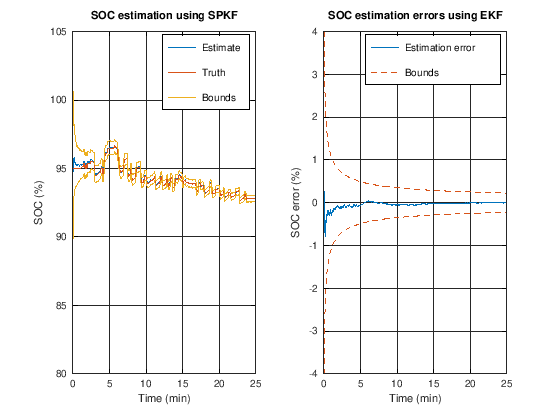

In [5]:
% Load model file corresponding to a cell of this type
% Has the variables: current, SOC, time, voltage
load readonly/PAN_CAPSTONE_DATA.mat; % load data from Panasonic NMC cell, +25 degC
T = 25; % Test temperature

time    = DYNData.script1.time(:);   deltat = time(2)-time(1);
time    = time-time(1); % start time at 0
current = DYNData.script1.current(:); % discharge > 0; charge < 0.
voltage = DYNData.script1.voltage(:);
soc     = DYNData.script1.soc(:);

% Load cell-test data to be used for this batch experiment
% Contains variable "DYNData" of which the field "script1" is of 
% interest. This has sub-fields time, current, voltage, soc.
load readonly/PANmodel.mat; % load ESC model of Panasonic NMC cell

% Reserve storage for computed results, for plotting
sochat = zeros(size(soc));
socbound = zeros(size(soc));

% Get tuning values from user-modified function
[SigmaW, SigmaV, SigmaZ0] = tuneSPKF;

SigmaX0 = diag([1e-6 1e-6 SigmaZ0]);
spkfData = initSPKF(voltage(1),T,SigmaX0,SigmaV,SigmaW,model);
% This simulation tests the SPKF when there is an inital SOC-estimation error
% The true initial SOC is 95%, but we will initialize the SOC estimate in the 
% filter to 90% and see how quickly and well the filter converges toward the
% correct SOC.
spkfData.xhat(spkfData.zkInd)=0.90; % 

% Now, enter loop for remainder of time, where we update the SPKF
% once per sample interval
fprintf('Please be patient. This code will take a minute or so to execute.\n')
for k = 1:length(voltage),
  vk = voltage(k); % "measure" voltage
  ik = current(k); % "measure" current
  Tk = T;          % "measure" temperature
  
  % Update SOC (and other model states)
  [sochat(k),socbound(k),spkfData] = iterSPKF(vk,ik,Tk,deltat,spkfData);
  % update waitbar periodically, but not too often (slow procedure)
  if mod(k,300)==0,
    fprintf('  Completed %d out of %d iterations...\n',k,length(voltage));
  end  
end

%%
subplot(1,2,1); plot(time/60,100*sochat,time/60,100*soc); hold on
plot([time/60; NaN; time/60],[100*(sochat+socbound); NaN; 100*(sochat-socbound)]);
title('SOC estimation using SPKF'); grid on
xlabel('Time (min)'); ylabel('SOC (%)'); legend('Estimate','Truth','Bounds');

%%
J1 = sqrt(mean((100*(soc-sochat)).^2));
fprintf('RMS SOC estimation error = %g%%\n',J1);

%%
J2 = 100*socbound(end);
fprintf('Final value of SOC estimation error bounds = %g%%\n',J2);

%%
subplot(1,2,2); plot(time/60,100*(soc-sochat)); hold on
plot([time/60; NaN; time/60],[100*socbound; NaN; -100*socbound],'--');
title('SOC estimation errors using EKF');
xlabel('Time (min)'); ylabel('SOC error (%)'); ylim([-4 4]); 
legend('Estimation error','Bounds'); 
grid on

ind = find(abs(soc-sochat)>socbound);
fprintf('Percent of time error outside bounds = %g%%\n',length(ind)/length(soc)*100);

% Compute the prospective grade
tableRow = min(11,ceil(max(0,J1-0.1)/0.01 + 1));
tableCol = min(11,ceil(max(0,J2-0.2)/0.02 + 1));
table = hankel([10:-1:0]);
grade = table(tableRow,tableCol);
if ~isempty(ind),
  fprintf('Your SOC estimation error was sometimes outside of bounds, so your overall grade is 0/10.');
else
  fprintf('Your grade is calculated from row %d and column %d of the grading table that is\n',tableRow,tableCol);
  fprintf('listed in the project description page. This will result in a grade of %d/10.\n',grade);
end


When you are satisfied with your tuning, click on the "<b>Submit Assignment</b>" button, above.

The assignment will be graded out of a maximum of 10 points possible. Part of the grade depends on the root-mean-squared SOC estimation error of your tuned filter. Part of the grade depends on the final value of the 3-sigma bounds on the SOC estimate. Part of the grade depends on whether your estimate is ever outside of the 3-sigma bounds.
* If your code produces errors when executed, the grade is zero
* If your SOC estimation error is ever outside the 3-sigma bounds, the grade is zero
* Otherwise, your grade can be found looking up the RMS SOC estimation error and the final value of the 3-sigma bounds in the grading table given in the project description page (the value is also computed by this code, for easy reference).
 * For a grade of 100%, you will need to achieve an RMS SOC estimation error of less than 0.1% and a final SOC esimtation error bound of less than 0.2%

If you are curious, the best results that I have been able to obtain are:
* RMS SOC estimation error = 0.098%
* Final value of SOC estimation error bounds = 0.197%

It took me quite a long time to find these good results, and I also discovered that the SPKF is far more sensitive to one of its tuning values than the other two. 